<a href="https://colab.research.google.com/github/noahu22/2015/blob/master/Waves_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Hampshire/ Southern Maine Wave Data Visualization (Seeking Barrels)

# Importing/ Cleaning Data

In [0]:
#Import Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [362]:
#Mount Google Drive & Create DF
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/My Drive/ufcdata/Waves Visualisation Project/wave_data.csv')

Mounted at /content/drive


In [0]:
#Drop NA values
#For this dataset the timestamps were every 15 minutes for wdir and wspd but every half hour for wvspd & wvhgt
#So I decided to drop all rows with na values which cut the dataset in half.
df.dropna(axis=0,how='any',inplace=True)

In [365]:
# This function is specifically for finding and cleaning impropery formatted dates from this dataset
list_of_short_dates=[]
for string in df.time:
  if len(string)==len(df.time[0]):
    pass
  else:
    list_of_short_dates.append(string)
print(list_of_short_dates)
df[df.time==list_of_short_dates[0]]
df.drop([52290],axis=0,inplace=True)


['Time (UTC)']


In [366]:
#change this one missing wdir value from 0 to 4
df[df.wdir=='0'].iloc[0]
df.wdir[65721]='N'

time      2018-04-14 09:30:00 UTC
height                        2.8
period                          8
wdir                            0
wspd                           11
Name: 65721, dtype: object

In [0]:
#rename columns
columns=['time','wvhgt','wvper','wdir','wspd']
df.columns=columns

In [0]:
#remove 'UTC' from timestamp and reset the index for some reason...
def remove_utc(string):
  newstring=string.split()[:2]
  newstring=' '.join(newstring)
  return newstring
df.time=df.time.apply(remove_utc)
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

In [0]:
#split timestamp into seperate columns & clean up the place a little bit
#I should totally convert these to int here but clean code is overrated
df['new_time']=df.time.apply(lambda string:string.split()[1])
df['year']=df.time.apply(lambda string:string.split()[0].split('-')[0])
df['month']=df.time.apply(lambda string:string.split()[0].split('-')[1])
df['day']=df.time.apply(lambda string:string.split()[0].split('-')[2])
df.drop(['time'],axis=1,inplace=True)
df['time']=df.new_time
df.drop(['new_time'],axis=1,inplace=True)

In [0]:
#encode wdir using cat
df.wdir=df.wdir.astype('category')
wdir_cat = dict(enumerate(df.wdir.cat.categories))
df.wdir=df.wdir.cat.codes

In [438]:
#lets just check this thing to make sure it's looking alright
df.head()

,wvhgt,wvper,wdir,wspd,year,month,day,time
0,5.2,5.3,11.0,26.0,2017,01,01,0.0
1,5.9,5.3,11.0,27.0,2017,01,01,0.5
2,6.0,6.4,11.0,28.0,2017,01,01,1.0
3,6.0,5.3,11.0,29.0,2017,01,01,1.5
4,7.0,6.4,11.0,26.0,2017,01,01,2.0


In [380]:
#take a look at the coded values for our wdir
wdir_cat

{0: 'E',
 1: 'ENE',
 2: 'ESE',
 3: 'N',
 4: 'NE',
 5: 'NNE',
 6: 'NNW',
 7: 'NW',
 8: 'S',
 9: 'SE',
 10: 'SSE',
 11: 'SSW',
 12: 'SW',
 13: 'W',
 14: 'WNW',
 15: 'WSW'}

In [0]:
#change time to float
def change_time(string):
  newstring=string.split(':')
  if newstring[1]=="00":
    hour=newstring[0]
    final_time=float(hour)
    return(final_time)
  elif newstring[1]=='30':
    hour=newstring[0]
    final_time=float(hour)+.5
    return(final_time)
df.time=df.time.apply(change_time) 


In [0]:
#change all other quant vars to float from string because I just realized they're all string...
for col_name in df.columns[:4]:
  df[col_name]=df[col_name].astype(float)

In [0]:
#Save the cleaned csv
df.to_csv('cleaned_wave_data.csv', sep=',')

# ACTUAL ANALYSIS TIME (The Fun Stuff)

Wave Interval By Month

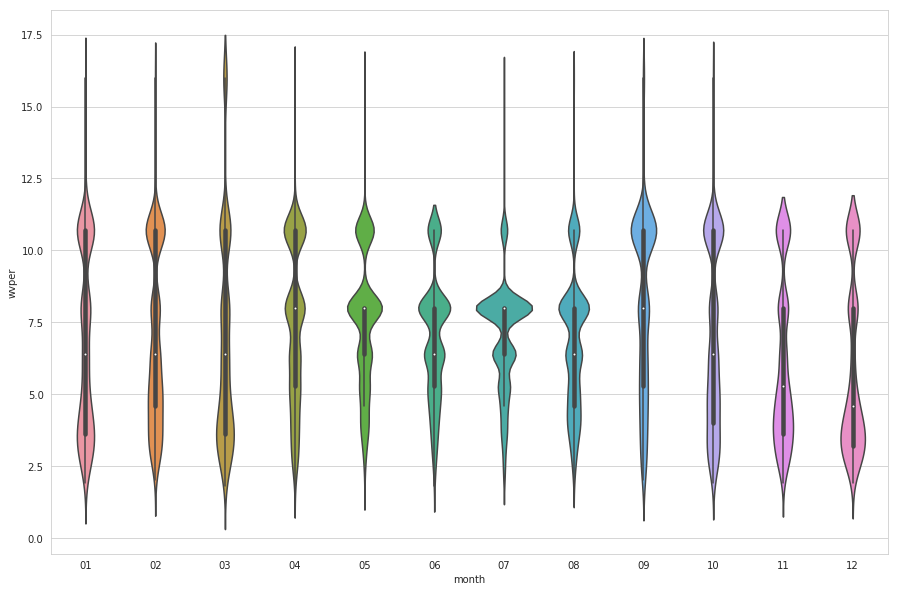

In [424]:
plt.figure(figsize=(15,10))
sns.violinplot(df.month,df.wvper)

Wave Height by Month

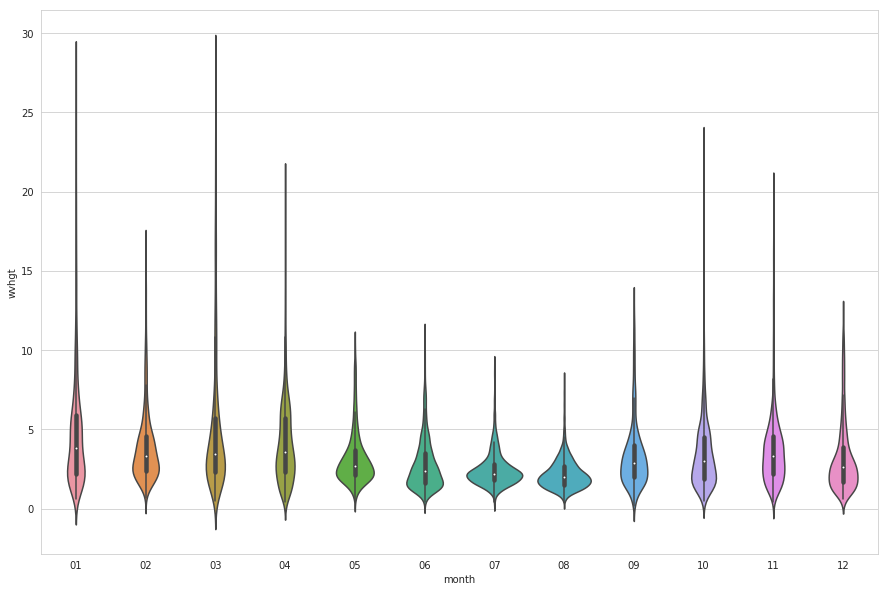

In [425]:
plt.figure(figsize=(15,10))
sns.violinplot(df.month,df.wvhgt)

Wind Speed by Hour of Day

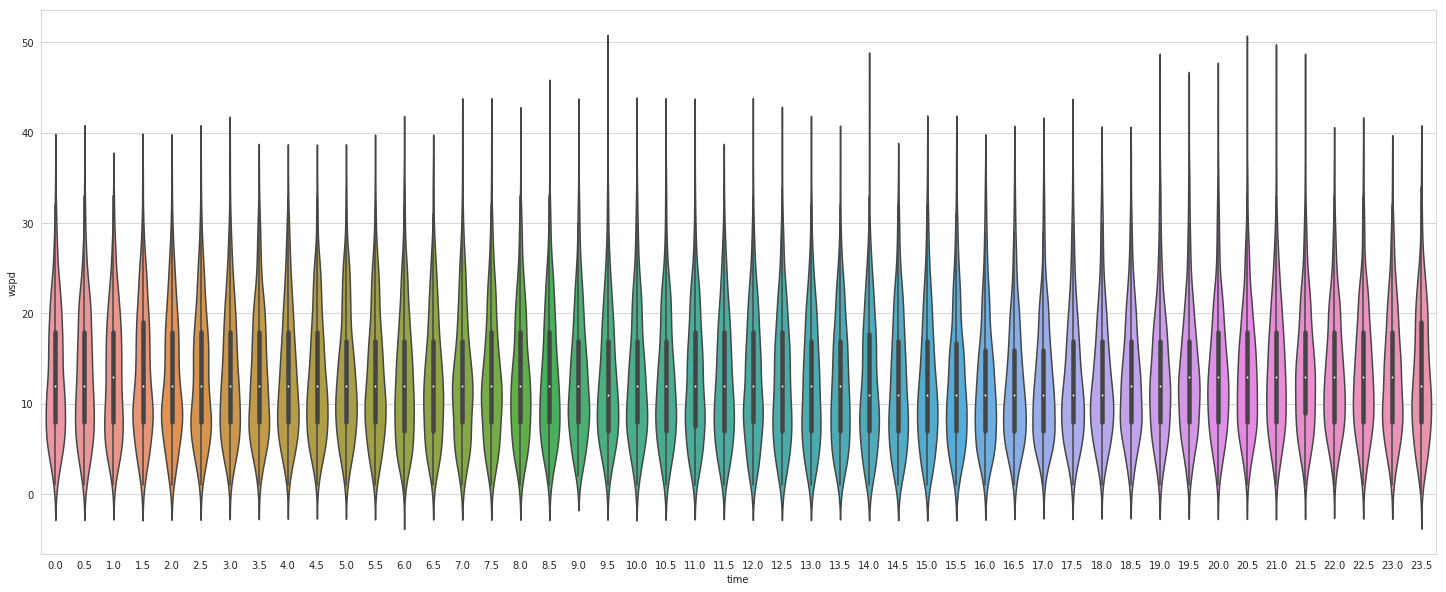

In [431]:
plt.figure(figsize=(25,10))
plt.tight_layout()
sns.violinplot(df.time,df.wspd)

{0: 'E', 1: 'ENE', 2: 'ESE', 3: 'N', 4: 'NE', 5: 'NNE', 6: 'NNW', 7: 'NW', 8: 'S', 9: 'SE', 10: 'SSE', 11: 'SSW', 12: 'SW', 13: 'W', 14: 'WNW', 15: 'WSW'}


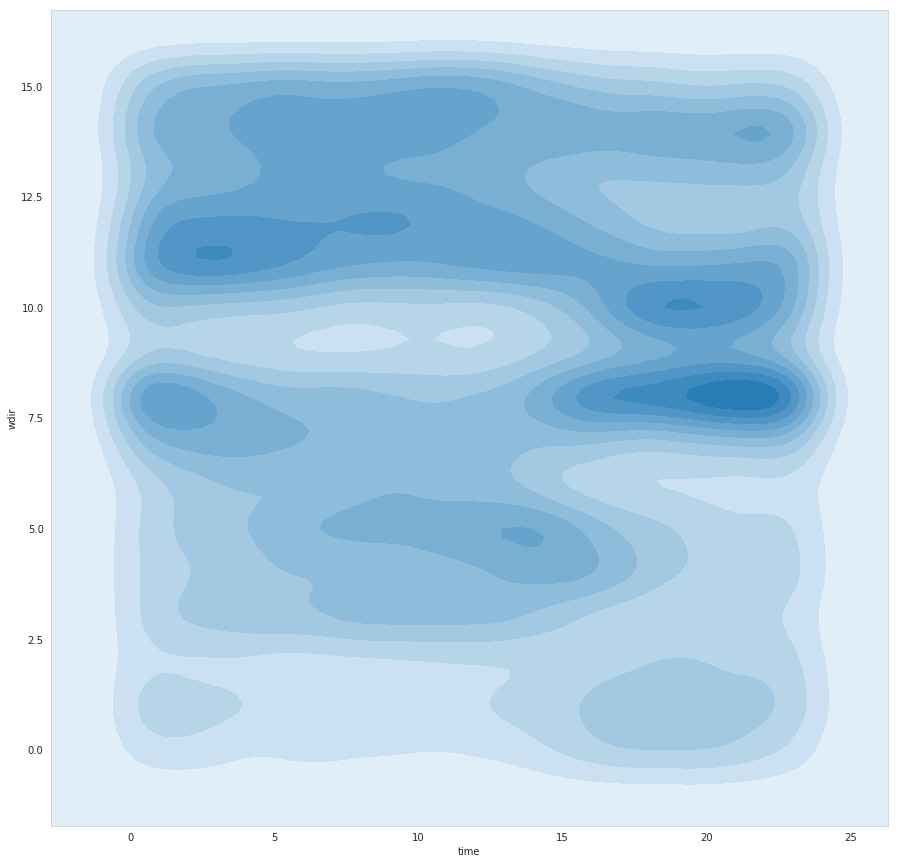

In [436]:
plt.figure(figsize=(15,15))
sns.kdeplot(df.time,df.wdir,shade=True)
print(wdir_cat)

In [0]:
#offshore vs onshore wind finder
offshore_winds=['WNW','WSW','W',]
onshore_winds=['ESE','ENE','E']
def wind_finder(num):
  wind_is=wdir_cat[int(num)]
  if wind_is in offshore_winds:
    return 0
  elif wind_is in onshore_winds:
    return 1
  else:
    return 2
df['off_or_on']=df.wdir.apply(wind_finder)

In [0]:
bigger_than_avg=df[df.wvhgt>df.wvhgt.mean()]

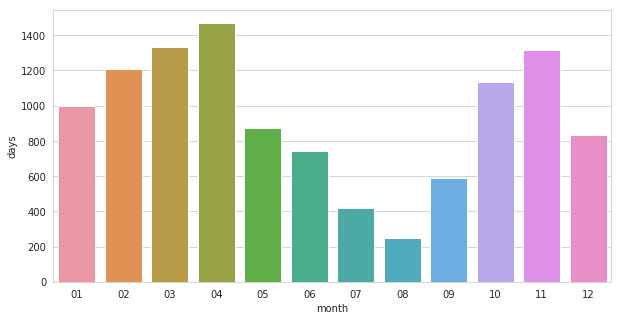

In [517]:
bigger_than_avg_months=bigger_than_avg.month.value_counts().to_frame().reset_index()
bigger_than_avg_months.columns=['month','days']
plt.figure(figsize=(10,5))
sns.barplot(bigger_than_avg_months.sort_values(by='month',ascending=True).month,bigger_than_avg_months.days)


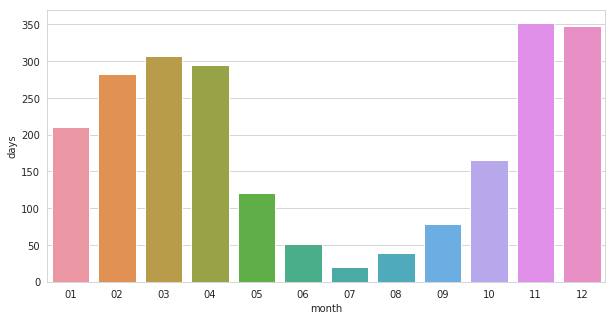

In [524]:
bigger_and_offshore=bigger_than_avg[bigger_than_avg.off_or_on==0]
bigger_and_offshore_months=bigger_and_offshore.month.value_counts().to_frame().reset_index()
bigger_and_offshore_months
bigger_and_offshore_months.columns=['month','days']
plt.figure(figsize=(10,5))
sns.barplot(bigger_and_offshore_months.sort_values(by='month',ascending=True).month,bigger_and_offshore_months.days)